In [26]:
import os
import uuid
import json
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# ────────────────────────────────────────────────────────────────────────────────
# 1) FIXED SETTINGS (data/schema only)
# ────────────────────────────────────────────────────────────────────────────────
categories_map = {
    'Input 1': [1, 2],
    'Input 2': list(range(1, 6)),
    'Input 3': list(range(1, 6)),
    'Input 4': list(range(1, 22)),
    'Input 5': list(range(1, 6)),
    'Input 6': [1, 2, 3],
    'Input 7': [1, 2, 3, 4],
    'Input 8': list(range(1, 11)),
}
all_inputs       = [f'Input {i}' for i in range(1, 19)]
z_inputs         = [c for c in all_inputs if c not in ('Input 10','Input 12')]
numeric_z_inputs = [f'Input {i}' for i in range(9, 19) if i not in (10, 12)]

# ────────────────────────────────────────────────────────────────────────────────
# 2) MODEL ARCHITECTURE
# ────────────────────────────────────────────────────────────────────────────────
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dims, activation):
        super().__init__()
        layers = []
        for h in hidden_dims:
            layers.append(nn.Linear(in_dim, h))
            if activation == 'relu':     layers.append(nn.ReLU())
            elif activation == 'tanh':    layers.append(nn.Tanh())
            elif activation == 'sigmoid': layers.append(nn.Sigmoid())
            elif activation == 'softplus':layers.append(nn.Softplus())
            else: raise ValueError(f"Unknown activation '{activation}'")
            in_dim = h
        layers.append(nn.Linear(in_dim, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

class PolyNet(nn.Module):
    def __init__(self, z_dim, hidden_dims, activation):
        super().__init__()
        self.A = MLP(z_dim, hidden_dims, activation)
        self.B = MLP(z_dim, hidden_dims, activation)
        self.C = MLP(z_dim, hidden_dims, activation)
        self.softplus = nn.Softplus()

    def forward(self, Z, x10):
        a = -self.softplus(self.A(Z))
        b = self.B(Z)
        c = self.C(Z)
        return a * (x10**2) + b * x10 + c

# ────────────────────────────────────────────────────────────────────────────────
# 3) CROSS-VALIDATION WITH HISTORY AND MODEL COLLECTION
# ────────────────────────────────────────────────────────────────────────────────
def cross_validate_poly_net_with_history(
    df, k_folds, hidden_dims, activation,
    epochs, lr, batch_size, device, random_state
):
    # Drop F2/F3
    df = df.drop(columns=[c for c in ('F2','F3') if c in df.columns])

    # Normalize target
    y_np = df['Output'].to_numpy(dtype=np.float32).reshape(-1,1)
    y_mean, y_std = y_np.mean(), (y_np.std() if y_np.std()!=0 else 1.0)
    y = (y_np - y_mean) / y_std

    # Prepare Z and Input10
    Xz     = df[z_inputs].copy()
    x10_np = df['Input 10'].to_numpy(dtype=np.float32).reshape(-1,1)
    x10_mean, x10_std = x10_np.mean(), (x10_np.std() if x10_np.std()!=0 else 1.0)
    x10 = (x10_np - x10_mean) / x10_std

    # Encode Inputs 1–8 in Z
    for col, cats in categories_map.items():
        if col not in Xz.columns: continue
        if len(cats) == 2:
            Xz[col] = Xz[col].map({cats[0]: +1.0, cats[1]: -1.0})
        else:
            Xz[col] = pd.Categorical(Xz[col], categories=cats)
            d = pd.get_dummies(Xz[col], prefix=col)
            for c in cats:
                nm = f"{col}_{c}"
                if nm not in d.columns:
                    d[nm] = 0
            Xz = pd.concat([Xz.drop(columns=[col]), d], axis=1)

    # Normalize numeric Z features
    present = [c for c in numeric_z_inputs if c in Xz.columns]
    m, s = Xz[present].mean(), Xz[present].std().replace(0,1.0)
    Xz[present] = (Xz[present] - m) / s

    Z_np = Xz.to_numpy(dtype=np.float32)

    # K-Fold setup
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=random_state)
    fold_results, histories, models = [], [], []

    for fold, (tr, va) in enumerate(kf.split(Z_np), 1):
        Z_tr, Z_va     = Z_np[tr], Z_np[va]
        x10_tr, x10_va = x10[tr], x10[va]
        y_tr, y_va     = y[tr], y[va]

        ds_tr = TensorDataset(torch.from_numpy(Z_tr),
                              torch.from_numpy(x10_tr),
                              torch.from_numpy(y_tr))
        ds_va = TensorDataset(torch.from_numpy(Z_va),
                              torch.from_numpy(x10_va),
                              torch.from_numpy(y_va))
        ld_tr = DataLoader(ds_tr, batch_size=batch_size, shuffle=True)
        ld_va = DataLoader(ds_va, batch_size=batch_size)

        model   = PolyNet(z_dim=Z_tr.shape[1],
                          hidden_dims=hidden_dims,
                          activation=activation).to(device)
        opt     = torch.optim.Adam(model.parameters(), lr=lr)
        loss_fn = nn.MSELoss()

        tr_losses, va_losses = [], []
        tr_r2s,    va_r2s    = [], []

        for epoch in range(1, epochs+1):
            model.train()
            for Zb, x10b, yb in ld_tr:
                Zb, x10b, yb = Zb.to(device), x10b.to(device), yb.to(device)
                opt.zero_grad()
                loss_fn(model(Zb, x10b), yb).backward()
                opt.step()
            model.eval()
            with torch.no_grad():
                p_tr = model(torch.from_numpy(Z_tr).to(device),
                             torch.from_numpy(x10_tr).to(device)).cpu().numpy()
                p_va = model(torch.from_numpy(Z_va).to(device),
                             torch.from_numpy(x10_va).to(device)).cpu().numpy()
            tr_losses.append(mean_squared_error(y_tr, p_tr))
            va_losses.append(mean_squared_error(y_va, p_va))
            tr_r2s.append( max(0, min(1, r2_score(y_tr, p_tr))) )
            va_r2s.append( max(0, min(1, r2_score(y_va, p_va))) )

        fold_results.append({
            'fold':       fold,
            'train_true': y_tr.flatten(),
            'train_pred': p_tr.flatten(),
            'val_true':   y_va.flatten(),
            'val_pred':   p_va.flatten(),
        })
        histories.append((tr_losses, va_losses, tr_r2s, va_r2s))
        models.append(model)

    # Return models and normalization constants too
    return fold_results, histories, models, (y_mean, y_std, x10_mean, x10_std), Xz.columns.tolist()


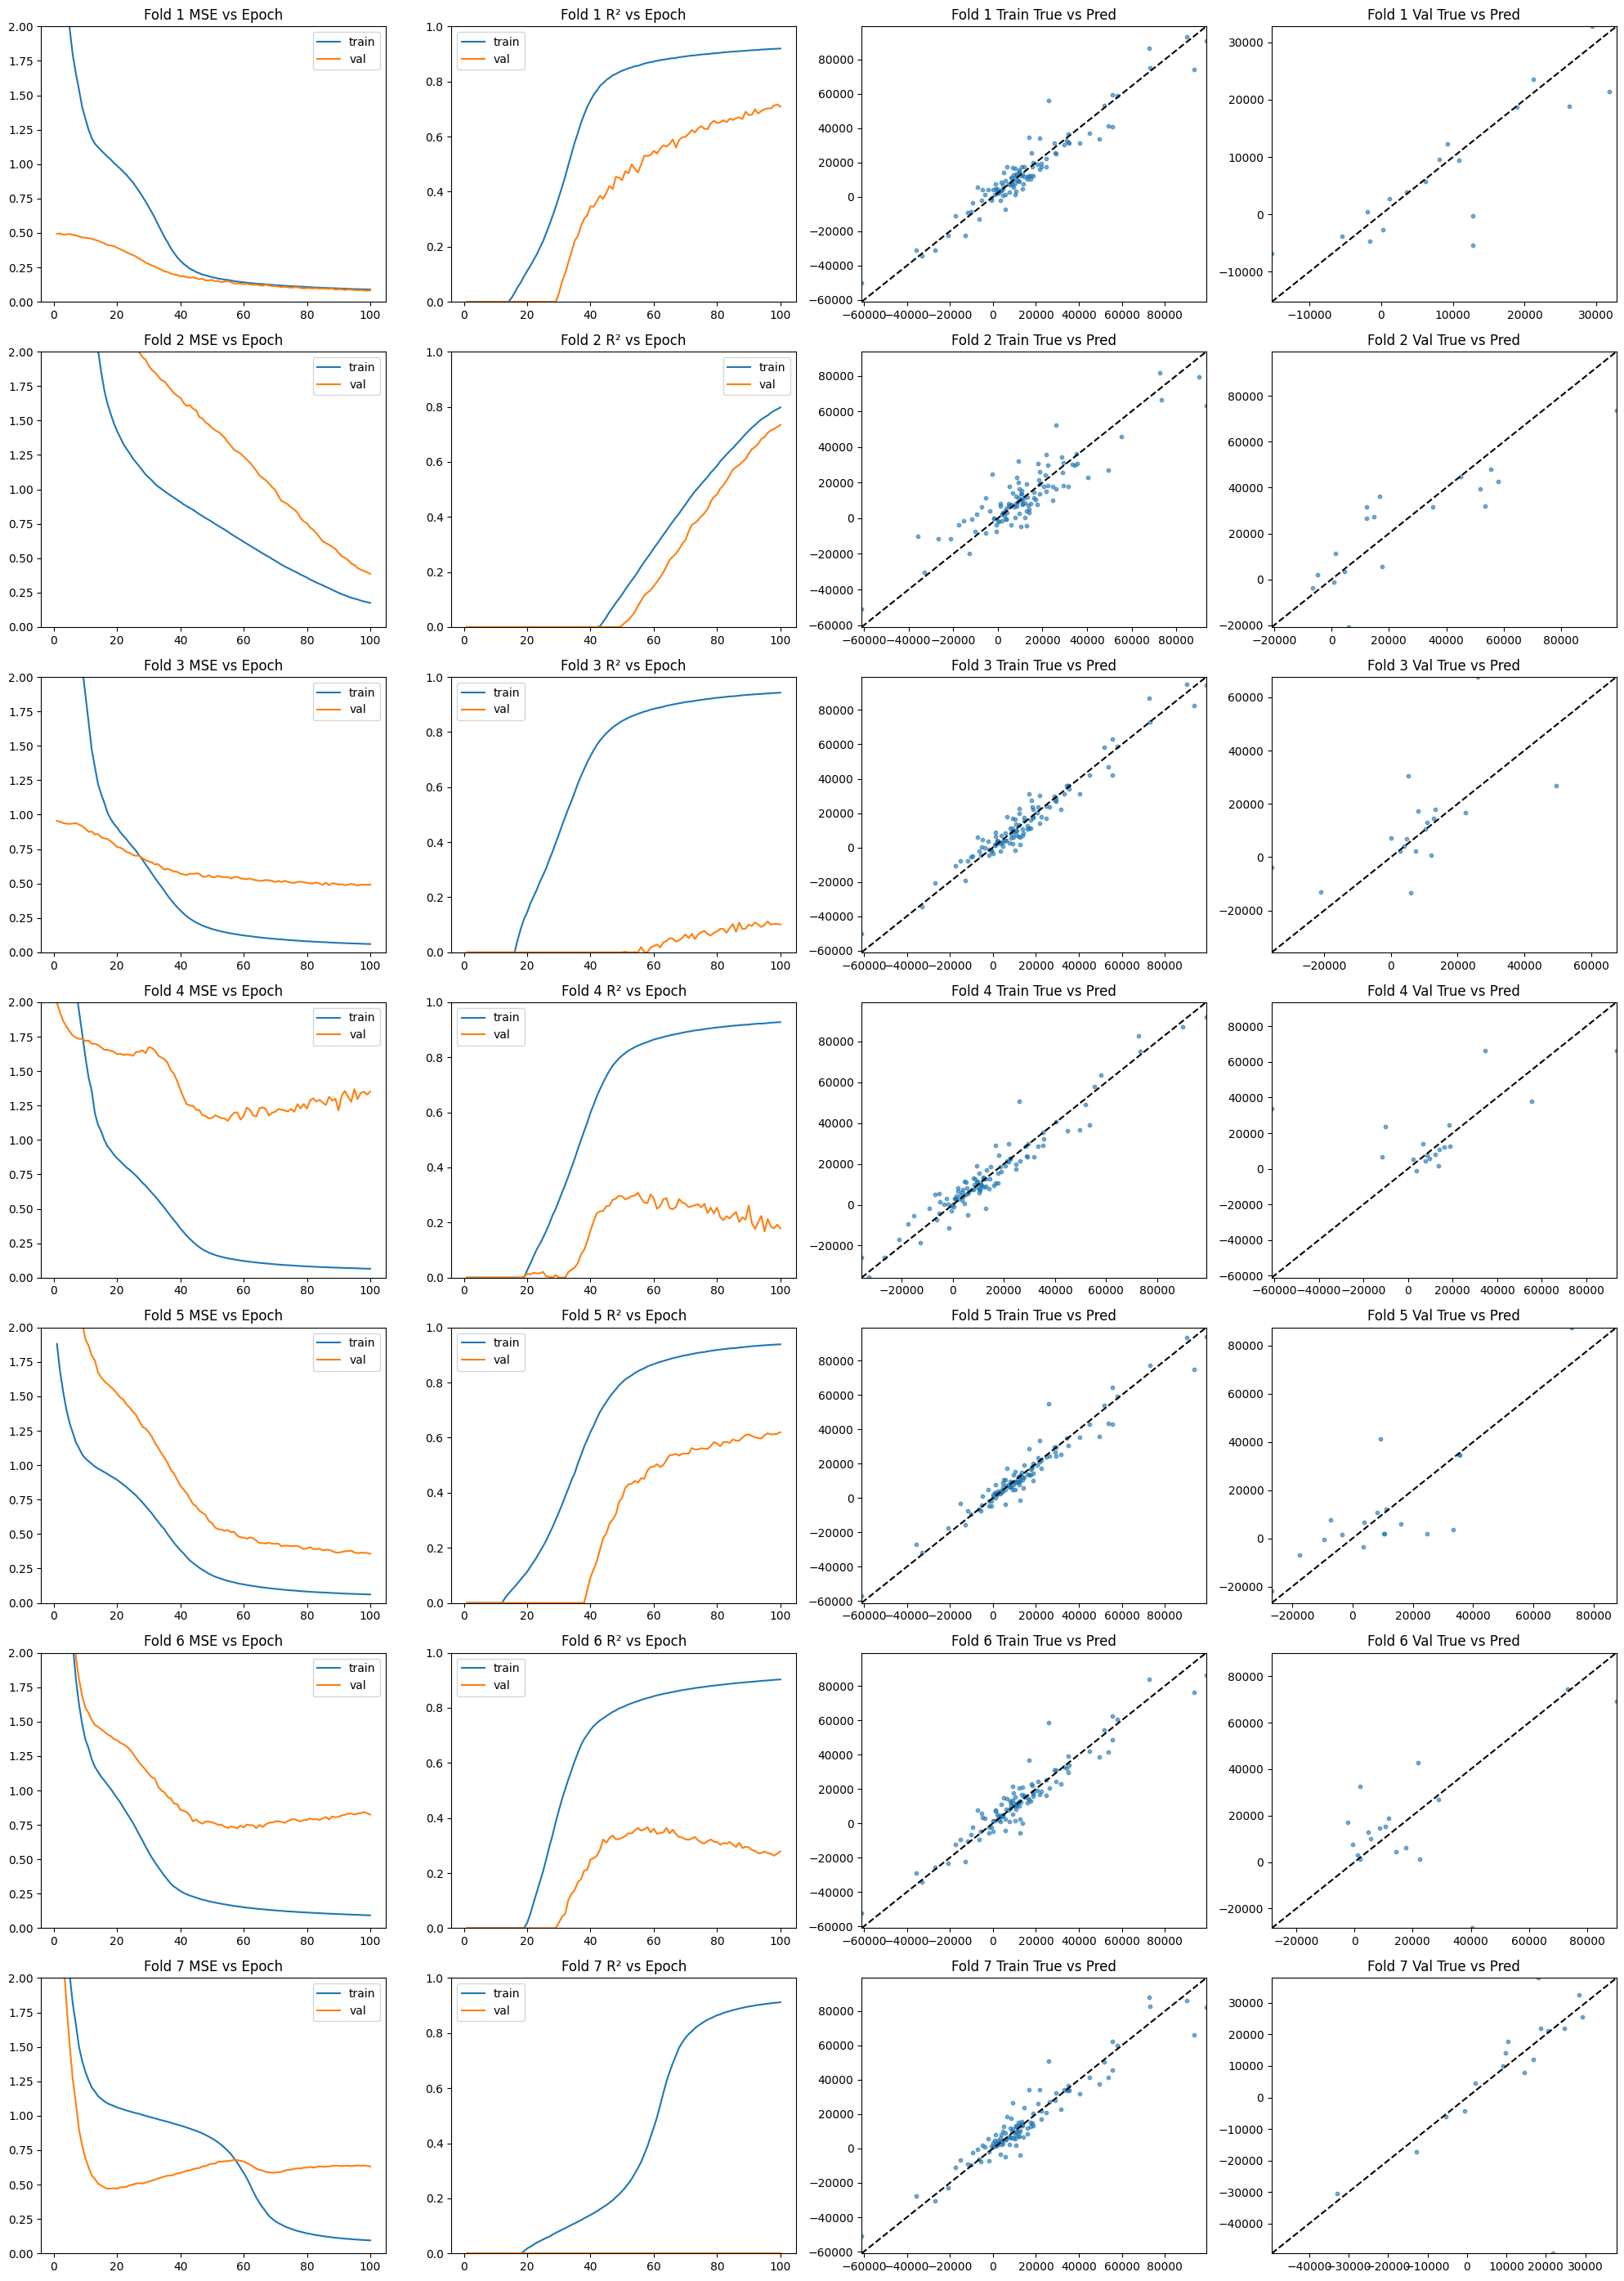

All outputs (models, hyperparams, plot) saved in ./7c7c5fc0/


In [27]:
# ────────────────────────────────────────────────────────────────────────────────
# 4) EXAMPLE USAGE, MODEL SAVING & PLOTTING
# ────────────────────────────────────────────────────────────────────────────────
if __name__ == '__main__':
    # Hyperparameters
    csv_path     = '/home/kamiar/chevron/Acid-neural-net/First Data-V2/data/train_val.csv'
    k_folds      = 7
    hidden_dims  = [4, 4]
    activation   = 'softplus'
    epochs       = 100
    lr           = 1e-3
    batch_size   = 8
    random_state = 42

    df     = pd.read_csv(csv_path)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    folds, histories, models, (y_m, y_s, x10_m, x10_s), feat_names = \
        cross_validate_poly_net_with_history(
            df, k_folds,
            hidden_dims, activation,
            epochs, lr, batch_size,
            device, random_state
        )

    # Generate a random tag and create folder
    tag = uuid.uuid4().hex[:8]
    os.makedirs(tag, exist_ok=True)

    # Save each fold's model
    for i, model in enumerate(models, start=1):
        path = os.path.join(tag, f"{tag}_fold{i}.pth")
        torch.save(model.state_dict(), path)

    # Save hyperparameters with the same tag
    hyperparams = {
        "csv_path": csv_path,
        "k_folds": k_folds,
        "hidden_dims": hidden_dims,
        "activation": activation,
        "epochs": epochs,
        "lr": lr,
        "batch_size": batch_size,
        "random_state": random_state
    }
    with open(os.path.join(tag, f"{tag}_hyperparams.json"), "w") as f:
        json.dump(hyperparams, f, indent=4)

    # Plot diagnostics: MSE, R², Train/Val scatter per fold
    fig, axes = plt.subplots(k_folds, 4, figsize=(20, 4*k_folds))
    for i, (fr, (tr_loss, va_loss, tr_r2, va_r2)) in enumerate(zip(folds, histories)):
        ax1, ax2, ax3, ax4 = axes[i]
        # MSE vs Epoch
        ax1.plot(range(1, epochs+1), tr_loss, label='train')
        ax1.plot(range(1, epochs+1), va_loss, label='val')
        ax1.set_title(f'Fold {fr["fold"]} MSE vs Epoch'); ax1.set_ylim(0, 2); ax1.legend()
        # R² vs Epoch
        ax2.plot(range(1, epochs+1), tr_r2, label='train')
        ax2.plot(range(1, epochs+1), va_r2, label='val')
        ax2.set_title(f'Fold {fr["fold"]} R² vs Epoch'); ax2.set_ylim(0, 1); ax2.legend()
        # Convert normalized to original
        yt_tr = fr['train_true'] * y_s + y_m
        yp_tr = fr['train_pred'] * y_s + y_m
        yt_va = fr['val_true']   * y_s + y_m
        yp_va = fr['val_pred']   * y_s + y_m
        # Train scatter
        ax3.scatter(yt_tr, yp_tr, s=10, alpha=0.6)
        lim3 = [min(yt_tr.min(), yp_tr.min()), max(yt_tr.max(), yp_tr.max())]
        ax3.plot(lim3, lim3, 'k--'); ax3.set_xlim(lim3); ax3.set_ylim(lim3)
        ax3.set_title(f'Fold {fr["fold"]} Train True vs Pred')
        # Val scatter
        ax4.scatter(yt_va, yp_va, s=10, alpha=0.6)
        lim4 = [min(yt_va.min(), yp_va.min()), max(yt_va.max(), yp_va.max())]
        ax4.plot(lim4, lim4, 'k--'); ax4.set_xlim(lim4); ax4.set_ylim(lim4)
        ax4.set_title(f'Fold {fr["fold"]} Val True vs Pred')

    plt.tight_layout()
    # Save the plot in the folder
    fig.savefig(os.path.join(tag, f"{tag}_diagnostics.png"))
    plt.show()

    print(f"All outputs (models, hyperparams, plot) saved in ./{tag}/")
